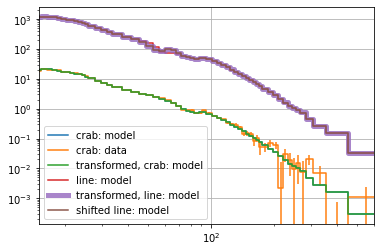

In [1]:
import numpy as np
import ogip
from ogip.tools import plot, transform_rmf, crab_ph_cm2_s_kev, convolve
import matplotlib.pylab as plt

crab_pha = ogip.spec.PHAI.from_file_name("crab_pha.fits")
crab_rmf = ogip.spec.RMF.from_file_name("crab_rmf.fits")
crab_arf = ogip.spec.ARF.from_file_name("crab_arf.fits")            

E0 = 60
rmf_bias = 5
depth = 1.


def gen_line(E0, depth):
    return lambda x: (x/20)**-2 * (1 - depth * np.exp(-(x-E0)**2/(E0*0.1)**2)/2)

f = plt.figure(figsize=(15, 10))

t_rmf = transform_rmf(crab_rmf, 
                    crab_arf, 
                    lambda x:(x+rmf_bias), 
                    preserved_projection=crab_ph_cm2_s_kev)

plot(crab_pha, crab_ph_cm2_s_kev, crab_rmf, crab_arf, fig=f, label_prefix="crab")    
plot(None, crab_ph_cm2_s_kev, t_rmf, crab_arf, fig=f, label_prefix="transformed, crab")

# Crab spectrum is the same with new and old RMF
s = convolve(crab_ph_cm2_s_kev, crab_rmf, crab_arf) 
t_s = convolve(crab_ph_cm2_s_kev, t_rmf, crab_arf)
assert np.all(np.abs((s - t_s)/s) < 0.001)

plot(None, gen_line(E0, depth), crab_rmf, crab_arf, fig=f, label_prefix="line")
plot(None, gen_line(E0, depth), t_rmf, crab_arf, fig=f, label_prefix="transformed, line", 
        plot_kwargs=dict(lw=5, alpha=0.8))
plot(None, gen_line(E0 - rmf_bias, depth), crab_rmf, crab_arf, fig=f, label_prefix="shifted line")

plt.savefig(f"conv_{E0}.png")
plt.savefig("conv.png")

# RMF transformation is equivalent to shifting. The match is not exact, but quite close
s = convolve(gen_line(E0, depth), crab_rmf, crab_arf) 
t_s = convolve(gen_line(E0 - rmf_bias, depth), t_rmf, crab_arf)

if E0 < 50: # else shape too affected
    assert np.nanstd(np.abs((s - t_s)/s)) < 0.05

t_rmf.to_fits("transformed_rmf.fits")
